<a href="https://colab.research.google.com/github/Anvarka/Crime_prediction/blob/main/Crime_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Модель 1: prophet, чтобы найти частоту преступления в зависимости от типа преступления и места. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler

In [3]:
#importing dataset
data=pd.read_csv('/content/drive/MyDrive/stl-crime-data_2008-2015.tsv', delimiter='\t', encoding='utf-8')
data = data[['DateOccured', 'Neighborhood', 'UCRCrime']]
data['DateOccured'] = [datetime.strptime(data.iloc[i]['DateOccured'], '%m/%d/%Y %H:%M').date() for i in range(len(data.index))]
data

,DateOccured,Neighborhood,UCRCrime
0,2000-01-01,53,Sex Offenses
1,2003-01-01,17,Larceny-theft
2,2004-01-01,68,Fraud
3,2006-01-01,16,Fraud
4,2007-01-01,57,Other assaults
...,...,...,...
477636,2013-12-01,5,Larceny-theft
477637,2013-12-20,65,Forcible Rape
477638,2014-12-22,14,Other assaults
477639,2014-12-26,60,Robbery


In [4]:
#keeping dates starting 2008
start = datetime.strptime('Jan 1 2008 00:00','%b %d %Y %H:%M').date()
filt = data['DateOccured'] >= start
data = data.where(filt)
data = data.dropna()

In [12]:
! pip install prophet

     |████████████████████████████████| 65 kB 2.2 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640538 sha256=6fb7f35460dfd7daebae95e6680ddccc47b7bbb9aee637e9caa1c4cd2234f536
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


# Частота криминала в районе в зависимости от места и типа преступления

1) Собираем количество преступлений в течении определенный даты:

In [52]:
res = data.groupby("DateOccured").count().reset_index()

,DateOccured,Neighborhood,UCRCrime,countCrime
0,2008-01-01,248,248,0
1,2008-01-02,173,173,0
2,2008-01-03,160,160,0
3,2008-01-04,199,199,0
4,2008-01-05,206,206,0
...,...,...,...,...
2917,2015-12-27,83,83,0
2918,2015-12-28,96,96,0
2919,2015-12-29,99,99,0
2920,2015-12-30,85,85,0


In [53]:
ds = pd.DataFrame()
res = data.groupby("DateOccured").count().reset_index()
ds["ds"] = res["DateOccured"]
ds["y"] = res["Neighborhood"]
ds

,ds,y
0,2008-01-01,248
1,2008-01-02,173
2,2008-01-03,160
3,2008-01-04,199
4,2008-01-05,206
...,...,...
2917,2015-12-27,83
2918,2015-12-28,96
2919,2015-12-29,99
2920,2015-12-30,85


2) Теперь добавим события, которые повлияют на динамику изменения количества преступлений:

In [54]:
data.head()

,DateOccured,Neighborhood,UCRCrime,countCrime
5,2008-01-01,49.0,Sexual Abuse,NaN
6,2008-01-01,39.0,Property Crimes,NaN
7,2008-01-01,15.0,Violence,NaN
8,2008-01-03,0.0,Other,NaN
9,2008-01-05,42.0,Property Crimes,NaN


In [55]:
propertyCrimes = pd.DataFrame({
  'holiday': 'Property Crimes',
  'ds': pd.to_datetime(data[data["UCRCrime"] == "Property Crimes"]["DateOccured"].astype(str).to_list()),
  'lower_window': 0,
  'upper_window': 1,
})
other = pd.DataFrame({
  'holiday': 'Other',
  'ds': pd.to_datetime(data[data["UCRCrime"] == "Other"]["DateOccured"].astype(str).to_list()),
  'lower_window': 0,
  'upper_window': 1,
})
sexualAbuse = pd.DataFrame({
  'holiday': 'Sexual Abuse',
  'ds': pd.to_datetime(data[data["UCRCrime"] == "Sexual Abuse"]["DateOccured"].astype(str).to_list()),
  'lower_window': 0,
  'upper_window': 1,
})
substanceAbuse = pd.DataFrame({
  'holiday': 'Substance Abuse',
  'ds': pd.to_datetime(data[data["UCRCrime"] == "Substance Abuse"]["DateOccured"].astype(str).to_list()),
  'lower_window': 0,
  'upper_window': 1,
})
vice = pd.DataFrame({
  'holiday': 'Vice',
  'ds': pd.to_datetime(data[data["UCRCrime"] == "Vice"]["DateOccured"].astype(str).to_list()),
  'lower_window': 0,
  'upper_window': 1,
})
violence = pd.DataFrame({
  'holiday': 'Violence',
  'ds': pd.to_datetime(data[data["UCRCrime"] == "Violence"]["DateOccured"].astype(str).to_list()),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((propertyCrimes, other, sexualAbuse, substanceAbuse, vice, violence))

3) Теперь обучим модель на основе этих событий:

In [56]:
import pandas as pd
from prophet import Prophet

model = Prophet(holidays=holidays)
model.fit(ds)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4) Предсказываем для сгенерированных дат как будет изменятся частота преступлений

In [57]:
future = model.make_future_dataframe(periods = 365)
forecast = model.predict(future)

In [58]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Other,Other_lower,Other_upper,Property Crimes,Property Crimes_lower,Property Crimes_upper,Sexual Abuse,Sexual Abuse_lower,Sexual Abuse_upper,Substance Abuse,Substance Abuse_lower,Substance Abuse_upper,Vice,Vice_lower,Vice_upper,Violence,Violence_lower,Violence_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-01,241.154306,221.080913,276.337121,241.154306,241.154306,34.907468,34.907468,34.907468,-6.676695,-6.676695,-6.676695,5.274090,5.274090,5.274090,8.112600,8.112600,8.112600,-6.676695,-6.676695,-6.676695,-6.676695,-6.676695,-6.676695,6.443923,6.443923,6.443923,28.264074,28.264074,28.264074,-2.489182,-2.489182,-2.489182,-19.330969,-19.330969,-19.330969,0.0,0.0,0.0,247.598229
1,2008-01-02,241.121274,145.633838,201.967520,241.121274,241.121274,30.756558,30.756558,30.756558,-34.396192,-34.396192,-34.396192,7.019149,7.019149,7.019149,15.917325,15.917325,15.917325,-34.396192,-34.396192,-34.396192,-34.396192,-34.396192,-34.396192,-68.159886,-68.159886,-68.159886,-49.495545,-49.495545,-49.495545,0.301125,0.301125,0.301125,-18.965466,-18.965466,-18.965466,0.0,0.0,0.0,172.961388
2,2008-01-03,241.088241,143.443024,197.701560,241.088241,241.088241,30.756558,30.756558,30.756558,-34.396192,-34.396192,-34.396192,7.019149,7.019149,7.019149,15.917325,15.917325,15.917325,-34.396192,-34.396192,-34.396192,-34.396192,-34.396192,-34.396192,-70.350283,-70.350283,-70.350283,-49.495545,-49.495545,-49.495545,-2.238842,-2.238842,-2.238842,-18.615896,-18.615896,-18.615896,0.0,0.0,0.0,170.737958
3,2008-01-04,241.055209,157.080107,211.502453,241.055209,241.055209,30.756558,30.756558,30.756558,-34.396192,-34.396192,-34.396192,7.019149,7.019149,7.019149,15.917325,15.917325,15.917325,-34.396192,-34.396192,-34.396192,-34.396192,-34.396192,-34.396192,-57.654557,-57.654557,-57.654557,-49.495545,-49.495545,-49.495545,10.134094,10.134094,10.134094,-18.293107,-18.293107,-18.293107,0.0,0.0,0.0,183.400652
4,2008-01-05,241.022176,150.655893,206.717270,241.022176,241.022176,30.756558,30.756558,30.756558,-34.396192,-34.396192,-34.396192,7.019149,7.019149,7.019149,15.917325,15.917325,15.917325,-34.396192,-34.396192,-34.396192,-34.396192,-34.396192,-34.396192,-63.079191,-63.079191,-63.079191,-49.495545,-49.495545,-49.495545,4.423532,4.423532,4.423532,-18.007179,-18.007179,-18.007179,0.0,0.0,0.0,177.942985


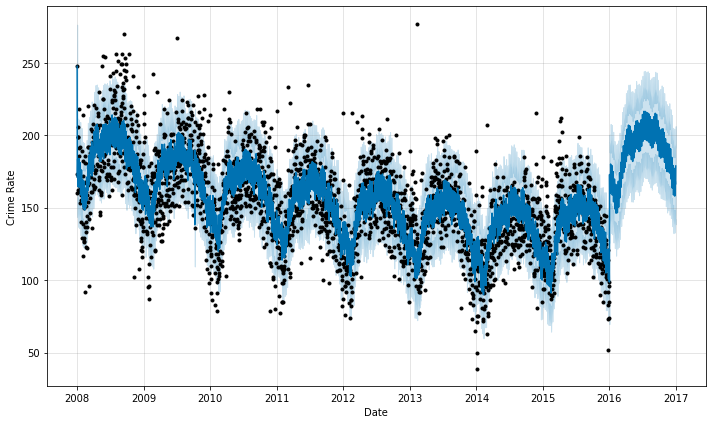

In [59]:
figure = model.plot(forecast, xlabel = 'Date', ylabel = 'Crime Rate')

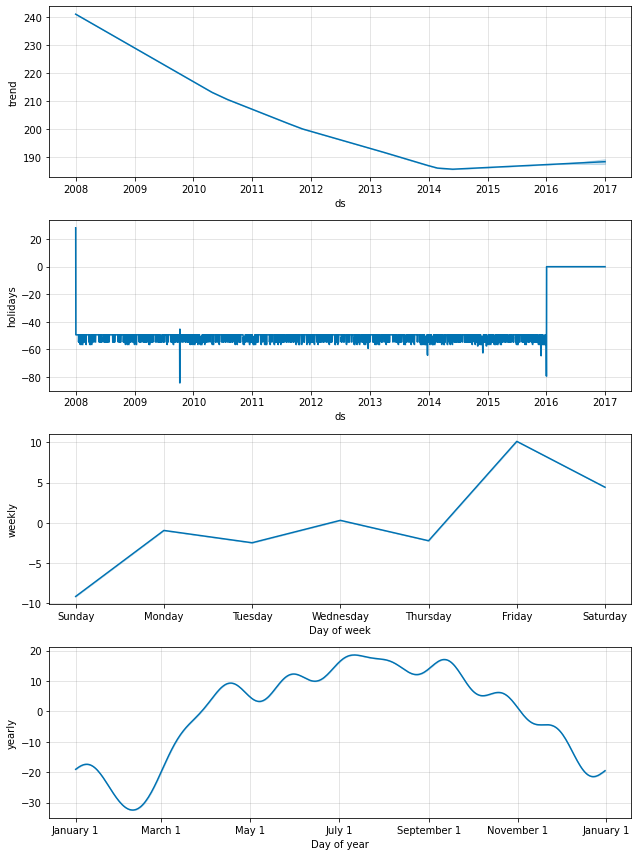

In [60]:
figure = model.plot_components(forecast)